In [ ]:
pip install yfinance scikit-learn pandas numpy matplotlib seaborn

In [ ]:
# 📦 Step 1: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Choose a stock ticker (e.g., AAPL)
ticker = "AAPL"

# Download historical stock data from Aug 1 to Nov 30, 2024
data = yf.download(ticker, start="2024-08-01", end="2024-12-01")

# Keep only required columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Open        High         Low       Close     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2024-08-01  223.325586  223.435074  216.009808  217.343567   62501000
2024-08-02  218.129877  224.549865  216.696592  218.836578  105568600
2024-08-05  198.163247  212.506173  195.087635  208.295868  119548600
2024-08-06  204.344342  209.012512  200.134036  206.265350   69660500
2024-08-07  205.936902  212.645533  205.429281  208.843323   63516400


In [ ]:
# Fill missing values (if any)
data.fillna(method='ffill', inplace=True)

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Prepare supervised learning data (window of past 5 days to predict next day)
def prepare_data(df, window_size=5):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i-window_size:i].values.flatten())
        y.append(df.iloc[i]['Close'])  # predicting 'Close' price
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_df)

<ipython-input-4-c2f6823a31b5>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# Train-Test split (last 15 days are for testing)
train_X, test_X = X[:-15], X[-15:]
train_y, test_y = y[:-15], y[-15:]

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

# Predict on test data (for Dec 1–15)
predictions_scaled = model.predict(test_X)
predictions = scaler.inverse_transform(np.hstack((np.zeros((15, 4)), predictions_scaled.reshape(-1, 1))))[:, -1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
actual_prices = actual_data['Close'].values
predictions = predictions[:len(actual_prices)]
mae = mean_absolute_error(actual_prices, predictions)
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 217483550.77
RMSE: 217632254.71


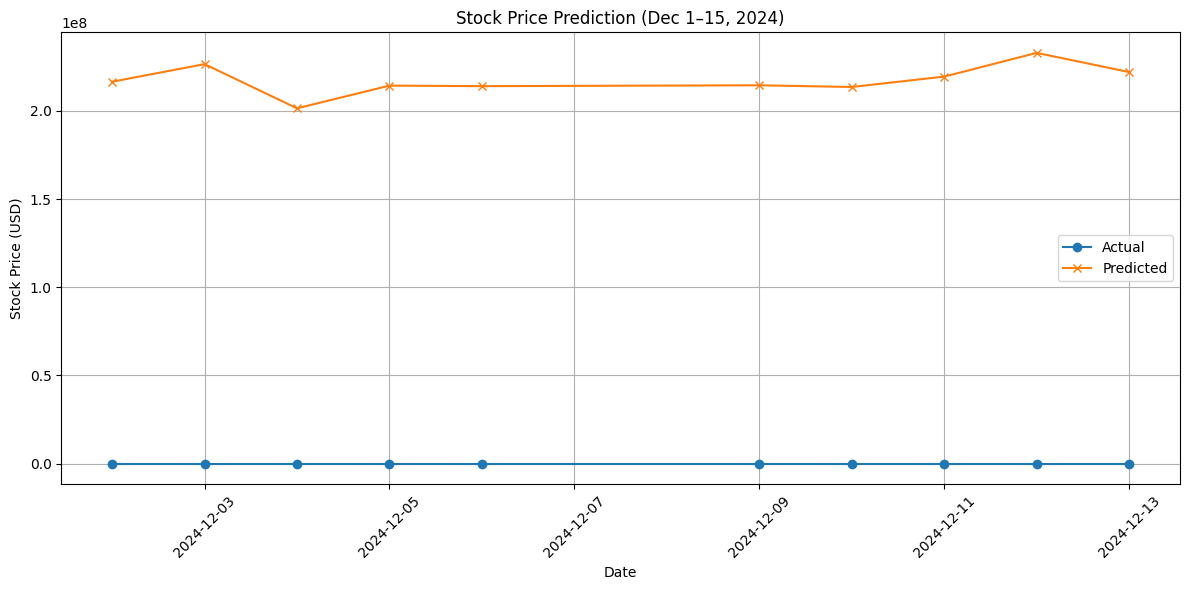

In [ ]:
# Visualization of Predicted vs Actual
dates = actual_data.index[:15]
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual', marker='o')
plt.plot(dates, predictions, label='Predicted', marker='x')
plt.title('Stock Price Prediction (Dec 1–15, 2024)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()